In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import median_absolute_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

uploaded_files = files.upload()
file = list(uploaded_files.keys())[0]


RANDOM_STATE = 42


# Loading Dataset Files
csv_path = file
df = pd.read_csv(csv_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensuring numeric core fields
for col in ["worldwide_gross", "production_budget", "profit_proxy", "roi_proxy",
            "tomatometer_rating", "tomatometer_count", "runtime", "star_power_score"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r"[,$]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )

Saving box_office_success_2015_2024_Updated.csv to box_office_success_2015_2024_Updated (1).csv
Data shape: (578, 25)
Columns: ['title', 'year', 'original_release_date_parsed', 'domestic_gross', 'international_gross', 'worldwide_gross', 'production_budget', 'profit_proxy', 'roi_proxy', 'tomatometer_rating', 'tomatometer_count', 'genres', 'runtime', 'directors', 'lead_actor', 'lead_actor_has_oscar', 'lead_actor_tier', 'lead_actor_status', 'star_power_score', 'is_animated', 'is_live_action', 'is_franchise', 'is_sequel', 'is_standalone', 'lead_actor_clean']


In [ ]:
def add_oof_target_encoding(train_df, test_df, col_name, target_name,
                            n_splits=5, random_state=RANDOM_STATE):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    global_mean = train_df[target_name].mean()
    # Index = train_df.index so we can use .loc safely
    te_train = pd.Series(index=train_df.index, dtype=float)

    # OOF encodings for TRAIN
    for tr_idx, val_idx in kf.split(train_df):
        tr = train_df.iloc[tr_idx]
        val = train_df.iloc[val_idx]

        means = tr.groupby(col_name)[target_name].mean()

        # Map categories to means; fallback to global mean
        te_vals = val[col_name].map(means).fillna(global_mean)

        # used .loc with label indices (val.index), not .iloc
        te_train.loc[val.index] = te_vals

    # Encodings for TEST: use full-train means only ---
    full_means = train_df.groupby(col_name)[target_name].mean()
    te_test = test_df[col_name].map(full_means).fillna(global_mean)

    return te_train, te_test

In [ ]:
# Dropped rows without core target/budget
df = df.dropna(subset=["worldwide_gross", "production_budget"]).copy()

# Target and log transforms
df["log_worldwide_gross"] = np.log1p(df["worldwide_gross"])
df["log_budget"] = np.log1p(df["production_budget"])
df["log_tomato_count"] = np.log1p(df["tomatometer_count"].fillna(0))

# Winsorize budget/gross  (same as before)
def winsorize(series, lower_q=0.01, upper_q=0.99):
    low, high = series.quantile(lower_q), series.quantile(upper_q)
    return series.clip(lower=low, upper=high)

df["worldwide_gross_wins"] = winsorize(df["worldwide_gross"])
df["production_budget_wins"] = winsorize(df["production_budget"])

# Primary genre
df["genres"] = df["genres"].fillna("Unknown")
df["primary_genre"] = df["genres"].str.split(",").str[0].str.lower().str.strip()

# Label encodings for tier/status
tier_map = {"C": 0, "B": 1, "A": 2}
status_map = {"well_known": 0, "trending": 1}
df["lead_actor_tier_enc"] = df["lead_actor_tier"].map(tier_map).fillna(0)
df["lead_actor_status_enc"] = df["lead_actor_status"].map(status_map).fillna(0)

df["year"] = pd.to_numeric(df["year"], errors="coerce")

print("After engineering:", df.shape)

After engineering: (578, 33)


In [ ]:
# For gross regression target
df = df.dropna(subset=["log_worldwide_gross"]).copy()

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("Train size:", train_df.shape[0])
print("Test size:", test_df.shape[0])


Train size: 462
Test size: 116


In [ ]:
te_train_dir, te_test_dir = add_oof_target_encoding(
    train_df, test_df,
    col_name="directors",
    target_name="log_worldwide_gross",
    n_splits=5
)
train_df["director_te"] = te_train_dir
test_df["director_te"] = te_test_dir

te_train_actor, te_test_actor = add_oof_target_encoding(
    train_df, test_df,
    col_name="lead_actor",
    target_name="log_worldwide_gross",
    n_splits=5
)
train_df["lead_actor_te"] = te_train_actor
test_df["lead_actor_te"] = te_test_actor


In [ ]:
def build_feature_sets(train_df, test_df, target_name):
    if target_name == "log_worldwide_gross":
        y_train = train_df[target_name].copy()
        y_test = test_df[target_name].copy()

        numeric_features = [
            "production_budget_wins",
            "log_budget",
            "profit_proxy",
            "roi_proxy",
            "tomatometer_rating",
            "log_tomato_count",
            "runtime",
            "star_power_score",
            "year",
            "is_animated",
            "is_live_action",
            "is_franchise",
            "is_sequel",
            "is_standalone",
            "lead_actor_has_oscar",
            "lead_actor_tier_enc",
            "lead_actor_status_enc",
            "director_te",
            "lead_actor_te",
        ]
    elif target_name == "roi_proxy":
        # Use only rows where ROI is defined
        train_df = train_df.dropna(subset=["roi_proxy"]).copy()
        test_df = test_df.dropna(subset=["roi_proxy"]).copy()
        y_train = train_df["roi_proxy"].copy()
        y_test = test_df["roi_proxy"].copy()

        numeric_features = [
            "production_budget_wins",
            "log_budget",
            "tomatometer_rating",
            "log_tomato_count",
            "runtime",
            "star_power_score",
            "year",
            "is_animated",
            "is_live_action",
            "is_franchise",
            "is_sequel",
            "is_standalone",
            "lead_actor_has_oscar",
            "lead_actor_tier_enc",
            "lead_actor_status_enc",
            "director_te",
            "lead_actor_te",
        ]
    else:
        raise ValueError("Unknown target")

    categorical_features = ["primary_genre"]

    numeric_features = [c for c in numeric_features if c in train_df.columns]
    categorical_features = [c for c in categorical_features if c in train_df.columns]

    X_train = train_df[numeric_features + categorical_features].copy()
    X_test = test_df[numeric_features + categorical_features].copy()

    return X_train, X_test, y_train, y_test, numeric_features, categorical_features


def make_preprocessor(numeric_features, categorical_features):
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor

def mean_absolute_percentage_error(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def symmetric_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.clip(denom, eps, None)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0



def tune_and_evaluate(X_train, y_train, X_test, y_test,
                      numeric_features, categorical_features,
                      target_name):

    preprocessor = make_preprocessor(numeric_features, categorical_features)

    models_and_grids = {
        "Ridge": (
            Ridge(random_state=RANDOM_STATE),
            {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
        ),
        "RandomForest": (
            RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
            {
                "model__n_estimators": [200, 400],
                "model__max_depth": [None, 10, 20],
                "model__max_features": ["sqrt", 0.7],
            },
        ),
        "GradientBoosting": (
            GradientBoostingRegressor(random_state=RANDOM_STATE),
            {
                "model__n_estimators": [200, 500],
                "model__learning_rate": [0.05, 0.1],
                "model__max_depth": [2, 3],
            },
        ),
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    summary_rows = {}
    best_pipes = {}

    for name, (base_model, param_grid) in models_and_grids.items():
        print(f"\n>>> Tuning {name} for {target_name}...")

        pipe = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", base_model),
            ]
        )

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=kfold,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
        )

        grid.fit(X_train, y_train)
        best_pipe = grid.best_estimator_
        best_pipes[name] = best_pipe

        print("  Best params:", grid.best_params_)
        print("  Best CV RMSE:", -grid.best_score_)

        # Test evaluation
        y_pred = best_pipe.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        # Core metrics (log-space or ROI)
        mae = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)

        if target_name == "log_worldwide_gross":
            y_test_dollars = np.expm1(y_test)
            y_pred_dollars = np.expm1(y_pred)
            rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))
            mae_dollars = mean_absolute_error(y_test_dollars, y_pred_dollars)
            medae_dollars = median_absolute_error(y_test_dollars, y_pred_dollars)

            mape = mean_absolute_percentage_error(y_test_dollars, y_pred_dollars) * 100
            smape = symmetric_mape(y_test_dollars, y_pred_dollars)
        else:
            rmse_dollars = np.nan
            mae_dollars = np.nan
            medae_dollars = np.nan

            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            smape = symmetric_mape(y_test, y_pred)

        summary_rows[name] = {
            "model": name,
            "target": target_name,

            "test_rmse": rmse,
            "test_r2": r2,
            "test_mae": mae,
            "test_medae": medae,

            "test_rmse_dollars": rmse_dollars,
            "test_mae_dollars": mae_dollars,
            "test_medae_dollars": medae_dollars,

            "test_mape_percent": mape,
            "test_smape_percent": smape,
        }

    summary_df = pd.DataFrame(summary_rows.values()).sort_values("test_rmse")
    print(f"\n=== Test results for target = {target_name} ===")
    print(summary_df.to_string(index=False))

    return best_pipes, summary_df

In [ ]:
# log(worldwide_gross)
Xtr_log, Xte_log, ytr_log, yte_log, num_log, cat_log = build_feature_sets(
    train_df, test_df, "log_worldwide_gross"
)
best_log_models, summary_log = tune_and_evaluate(
    Xtr_log, ytr_log, Xte_log, yte_log, num_log, cat_log, "log_worldwide_gross"
)

# ROI
Xtr_roi, Xte_roi, ytr_roi, yte_roi, num_roi, cat_roi = build_feature_sets(
    train_df, test_df, "roi_proxy"
)
best_roi_models, summary_roi = tune_and_evaluate(
    Xtr_roi, ytr_roi, Xte_roi, yte_roi, num_roi, cat_roi, "roi_proxy"
)



>>> Tuning Ridge for log_worldwide_gross...
  Best params: {'model__alpha': 1.0}
  Best CV RMSE: 0.1329130532946458

>>> Tuning RandomForest for log_worldwide_gross...
  Best params: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__n_estimators': 400}
  Best CV RMSE: 0.095411832068274

>>> Tuning GradientBoosting for log_worldwide_gross...
  Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500}
  Best CV RMSE: 0.072658949874053

=== Test results for target = log_worldwide_gross ===
           model              target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
    RandomForest log_worldwide_gross   0.190249 0.970552  0.039458    0.007944       6.688663e+07      1.161782e+07        4.803614e+05         325.301229            3.566110
           Ridge log_worldwide_gross   0.196296 0.968650  0.074893    0.036245       6.148581e+07      1.5208

Generating evaluation plots for: RandomForest


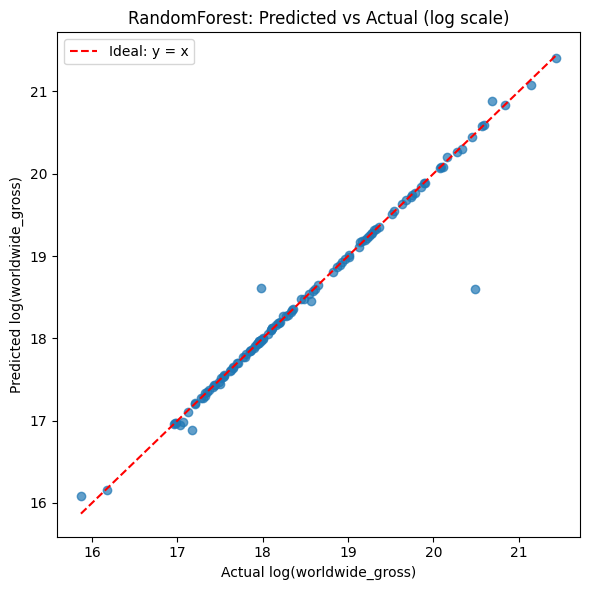

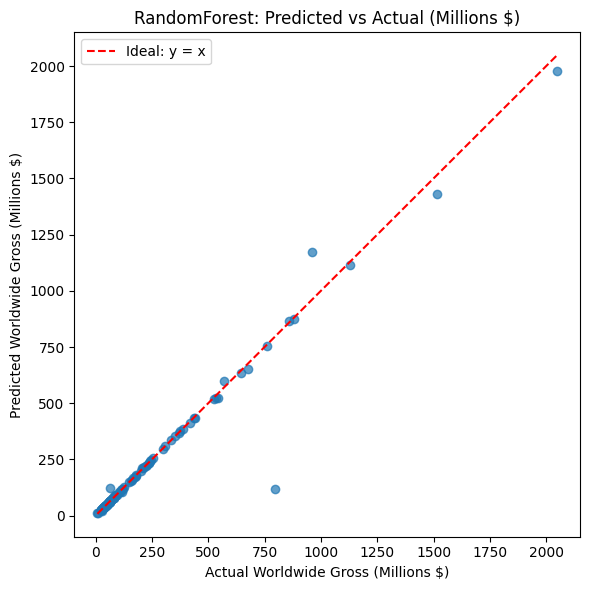

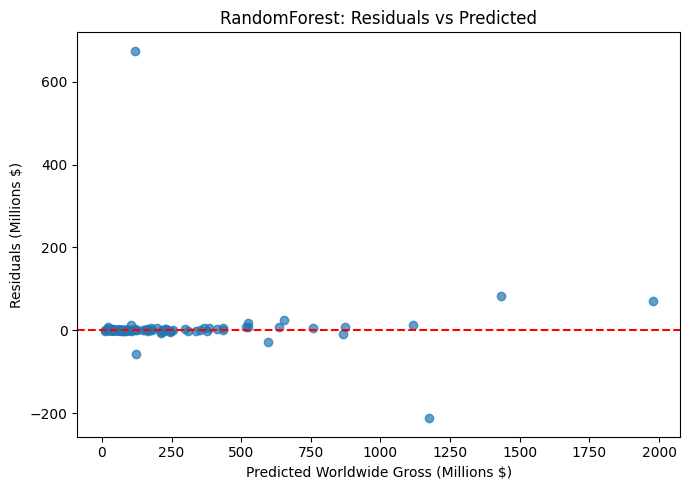

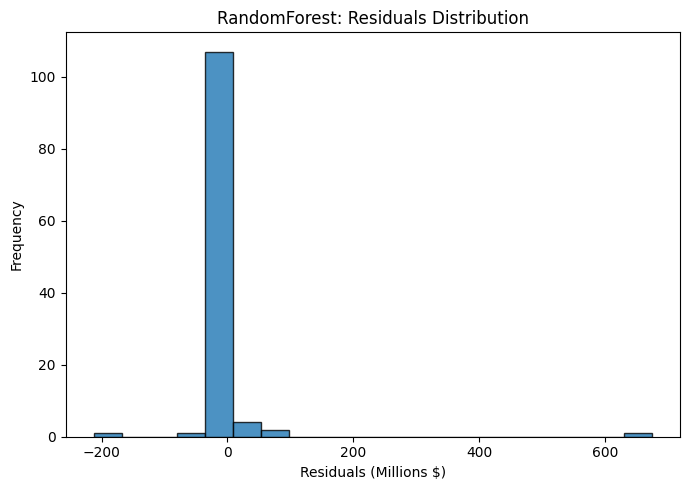


Final Model Comparison (sorted by Test RMSE):
           model              target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
    RandomForest log_worldwide_gross   0.190249 0.970552  0.039458    0.007944       6.688663e+07      1.161782e+07        4.803614e+05         325.301229            3.566110
           Ridge log_worldwide_gross   0.196296 0.968650  0.074893    0.036245       6.148581e+07      1.520841e+07        2.746449e+06         793.199714            7.184472
GradientBoosting log_worldwide_gross   0.201058 0.967110  0.037796    0.006485       6.972378e+07      1.297076e+07        6.111501e+05         308.362304            3.337193


In [ ]:
chosen_model_name = "RandomForest"
pipe_best = best_log_models[chosen_model_name]

print(f"Generating evaluation plots for: {chosen_model_name}")

# ---- Predictions ----
y_pred_test = pipe_best.predict(Xte_log)

# log-space
y_test_log = yte_log
y_pred_log = y_pred_test

# Convert back to dollars
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)

# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Histogram (dollars)
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()


# Print model comparison table
print("\nFinal Model Comparison (sorted by Test RMSE):")
print(summary_log.to_string(index=False))


Generating evaluation plots for: Ridge


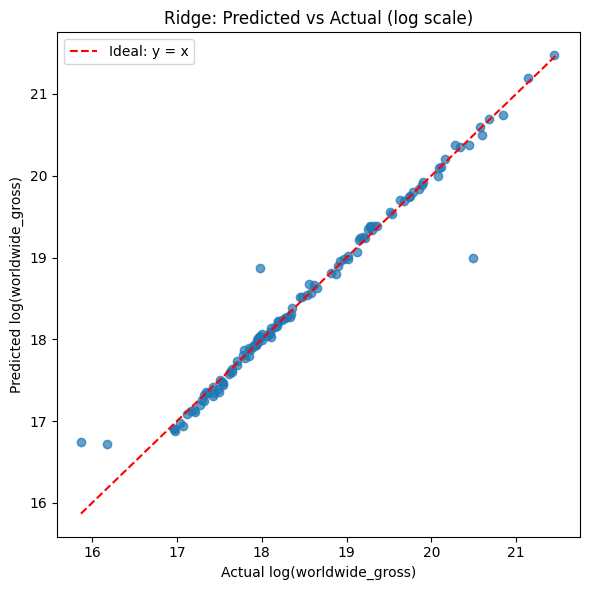

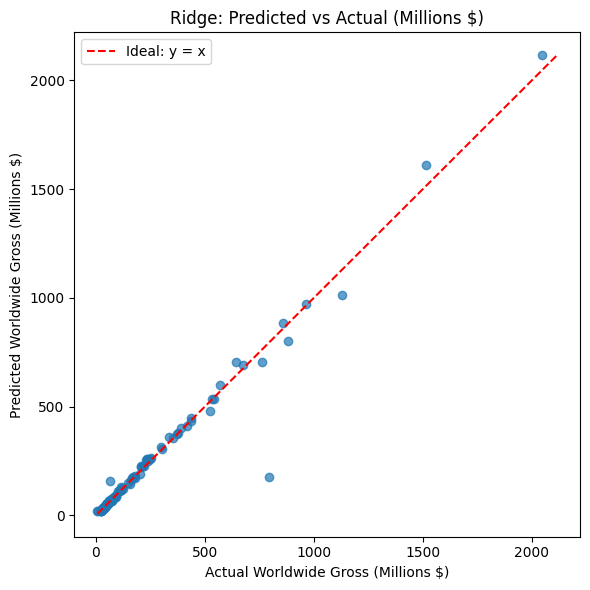

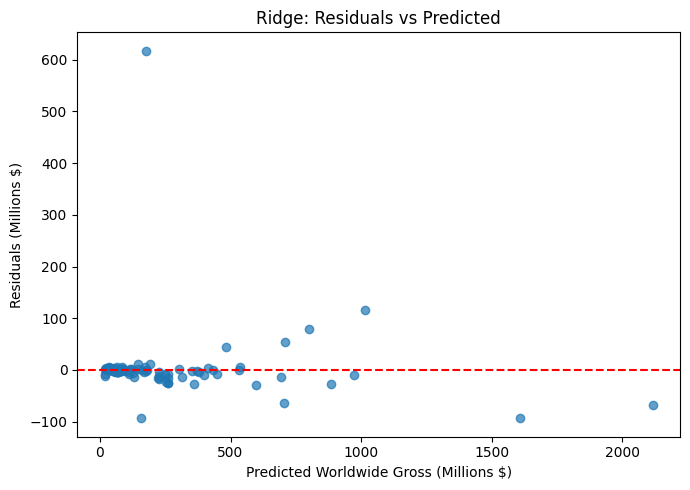

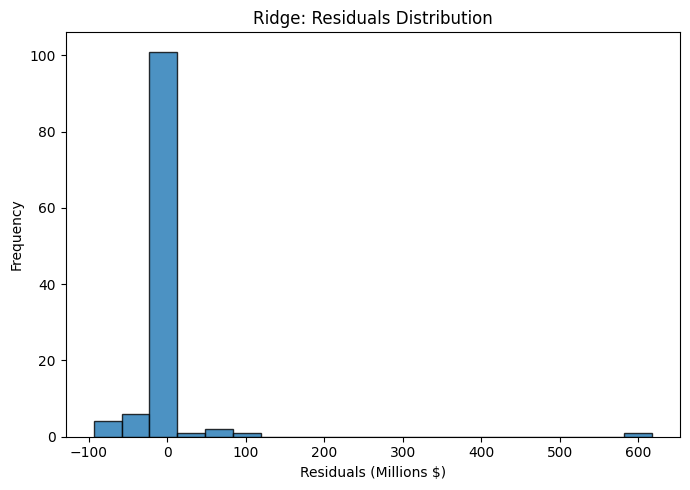


Final Model Comparison (sorted by Test RMSE):
           model              target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
    RandomForest log_worldwide_gross   0.190249 0.970552  0.039458    0.007944       6.688663e+07      1.161782e+07        4.803614e+05         325.301229            3.566110
           Ridge log_worldwide_gross   0.196296 0.968650  0.074893    0.036245       6.148581e+07      1.520841e+07        2.746449e+06         793.199714            7.184472
GradientBoosting log_worldwide_gross   0.201058 0.967110  0.037796    0.006485       6.972378e+07      1.297076e+07        6.111501e+05         308.362304            3.337193


In [ ]:
chosen_model_name = "Ridge"
pipe_best = best_log_models[chosen_model_name]

print(f"Generating evaluation plots for: {chosen_model_name}")

# ---- Predictions ----
y_pred_test = pipe_best.predict(Xte_log)

# log-space
y_test_log = yte_log
y_pred_log = y_pred_test

# Convert back to dollars
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)

# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Residuals Histogram (dollars)
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()


# Print model comparison table
print("\nFinal Model Comparison (sorted by Test RMSE):")
print(summary_log.to_string(index=False))


Generating evaluation plots for: GradientBoosting


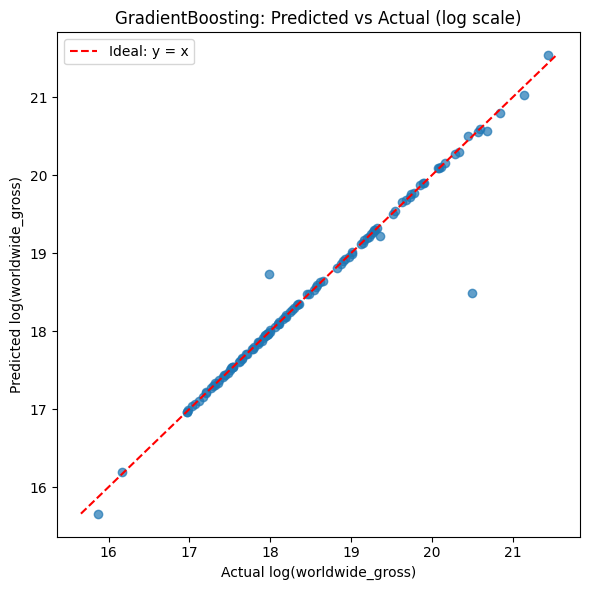

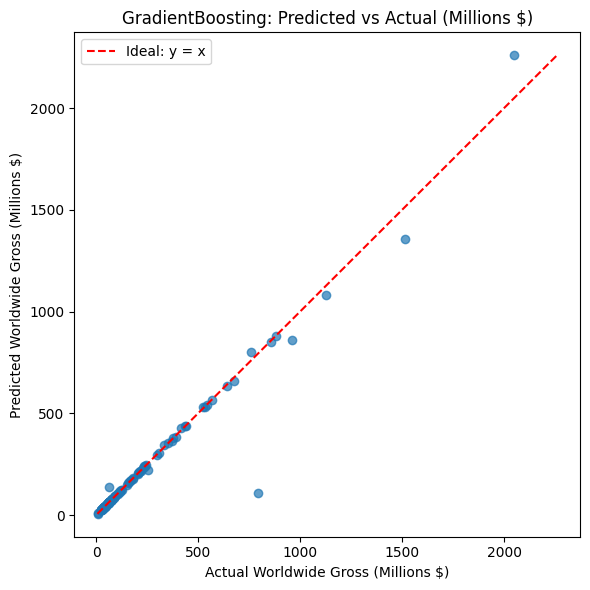

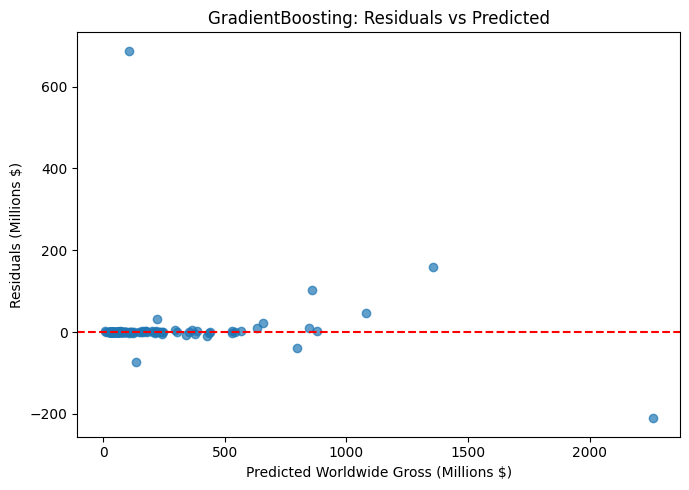

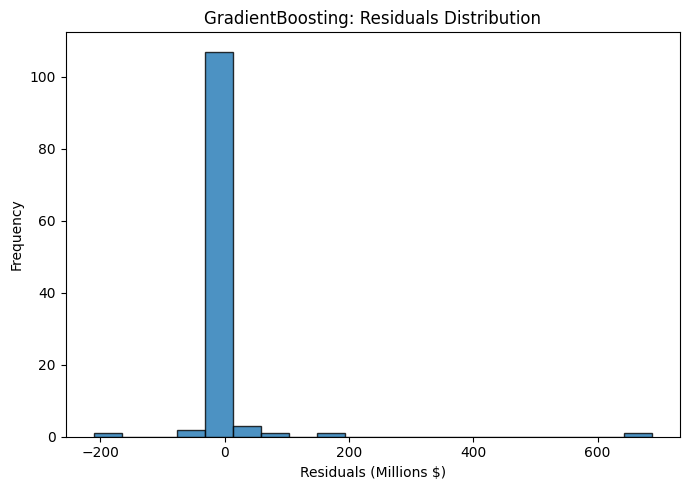


Final Model Comparison (sorted by Test RMSE):
           model              target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
    RandomForest log_worldwide_gross   0.190249 0.970552  0.039458    0.007944       6.688663e+07      1.161782e+07        4.803614e+05         325.301229            3.566110
           Ridge log_worldwide_gross   0.196296 0.968650  0.074893    0.036245       6.148581e+07      1.520841e+07        2.746449e+06         793.199714            7.184472
GradientBoosting log_worldwide_gross   0.201058 0.967110  0.037796    0.006485       6.972378e+07      1.297076e+07        6.111501e+05         308.362304            3.337193


In [ ]:

chosen_model_name = "GradientBoosting"
pipe_best = best_log_models[chosen_model_name]

print(f"Generating evaluation plots for: {chosen_model_name}")

# ---- Predictions ----
y_pred_test = pipe_best.predict(Xte_log)

# log-space
y_test_log = yte_log
y_pred_log = y_pred_test

# Convert back to dollars
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)


# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()


# Residuals Histogram (dollars)
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()

# model comparison table
print("\nFinal Model Comparison (sorted by Test RMSE):")
print(summary_log.to_string(index=False))


In [ ]:
def eval_by_bucket(df, y_true, y_pred, col="worldwide_gross"):
    temp = df.copy()
    temp["y_true"] = y_true
    temp["y_pred"] = y_pred

    # define buckets
    bins = [0, 50_000_000, 200_000_000, np.inf]
    labels = ["low", "mid", "high"]
    temp["gross_bucket"] = pd.cut(temp[col], bins=bins, labels=labels)

    for b in labels:
        sub = temp[temp["gross_bucket"] == b]
        if len(sub) == 0:
            continue
        rmse = np.sqrt(((sub["y_true"] - sub["y_pred"]) ** 2).mean())
        print(f"{b} (n={len(sub)}): RMSE = {rmse:,.0f}")


In [ ]:
# Make predictions in log space
y_pred_test = pipe_best.predict(Xte_log)

# Convert log → dollars
y_true_dollars = np.expm1(yte_log)
y_pred_dollars = np.expm1(y_pred_test)

# Call bucket evaluation
eval_by_bucket(
    test_df,
    y_true_dollars,
    y_pred_dollars,
    col="worldwide_gross"
)



low (n=32): RMSE = 384,038
mid (n=49): RMSE = 10,376,770
high (n=35): RMSE = 126,337,666


In [ ]:
df["is_blockbuster"] = (df["production_budget"] >= 100_000_000).astype(int)

df_block     = df[df["is_blockbuster"] == 1].copy()
df_nonblock  = df[df["is_blockbuster"] == 0].copy()

print(df_block.shape, df_nonblock.shape)
block_train, block_test = train_test_split(df_block, test_size=0.2, random_state=42)
nonblock_train, nonblock_test = train_test_split(df_nonblock, test_size=0.2, random_state=42)


# Blockbusters (log_worldwide_gross)

Xtr_b, Xte_b, ytr_b, yte_b, num_b, cat_b = build_feature_sets(
    block_train, block_test, "log_worldwide_gross"
)

best_block_models, summary_block = tune_and_evaluate(
    Xtr_b, ytr_b, Xte_b, yte_b,
    num_b, cat_b,
    "log_worldwide_gross (blockbusters)"
)


# NON-BLOCKBUSTERS (log_worldwide_gross)
Xtr_nb, Xte_nb, ytr_nb, yte_nb, num_nb, cat_nb = build_feature_sets(
    nonblock_train, nonblock_test, "log_worldwide_gross"
)

best_nonblock_models, summary_nonblock = tune_and_evaluate(
    Xtr_nb, ytr_nb, Xte_nb, yte_nb,
    num_nb, cat_nb,
    "log_worldwide_gross (non-blockbusters)"
)


(113, 34) (465, 34)

>>> Tuning Ridge for log_worldwide_gross (blockbusters)...
  Best params: {'model__alpha': 1.0}
  Best CV RMSE: 0.07602022991305372

>>> Tuning RandomForest for log_worldwide_gross (blockbusters)...
  Best params: {'model__max_depth': 20, 'model__max_features': 0.7, 'model__n_estimators': 200}
  Best CV RMSE: 0.17574784459343218

>>> Tuning GradientBoosting for log_worldwide_gross (blockbusters)...
  Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500}
  Best CV RMSE: 0.1531392699323912

=== Test results for target = log_worldwide_gross (blockbusters) ===
           model                             target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
GradientBoosting log_worldwide_gross (blockbusters)   0.168233 0.949772  0.063746    0.018133                NaN               NaN                 NaN          31.147582            0.31

In [ ]:
# Split dataset into franchise vs standalone groups
df_franchise  = df[df["is_franchise"] == 1].copy()
df_standalone = df[df["is_standalone"] == 1].copy()

print(df_franchise.shape, df_standalone.shape)

# Train/test splits INSIDE each subgroup
# (Required because build_feature_sets expects train_df + test_df)
from sklearn.model_selection import train_test_split

fr_train, fr_test = train_test_split(df_franchise,  test_size=0.2, random_state=42)
sa_train, sa_test = train_test_split(df_standalone, test_size=0.2, random_state=42)

# Franchise models — log(worldwide_gross)
Xtr_f, Xte_f, ytr_f, yte_f, num_f, cat_f = build_feature_sets(
    fr_train, fr_test, "log_worldwide_gross"
)

best_franchise_models, summary_franchise = tune_and_evaluate(
    Xtr_f, ytr_f, Xte_f, yte_f,
    num_f, cat_f,
    "log_worldwide_gross (franchise)"
)

# Standalone models — log(worldwide_gross)
Xtr_s, Xte_s, ytr_s, yte_s, num_s, cat_s = build_feature_sets(
    sa_train, sa_test, "log_worldwide_gross"
)

best_standalone_models, summary_standalone = tune_and_evaluate(
    Xtr_s, ytr_s, Xte_s, yte_s,
    num_s, cat_s,
    "log_worldwide_gross (standalone)"
)


(18, 34) (517, 34)

>>> Tuning Ridge for log_worldwide_gross (franchise)...
  Best params: {'model__alpha': 0.1}
  Best CV RMSE: 0.14424392437976746

>>> Tuning RandomForest for log_worldwide_gross (franchise)...
  Best params: {'model__max_depth': 20, 'model__max_features': 0.7, 'model__n_estimators': 400}
  Best CV RMSE: 0.31238791573031394

>>> Tuning GradientBoosting for log_worldwide_gross (franchise)...
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
  Best CV RMSE: 0.19008950788051232

=== Test results for target = log_worldwide_gross (franchise) ===
           model                          target  test_rmse  test_r2  test_mae  test_medae  test_rmse_dollars  test_mae_dollars  test_medae_dollars  test_mape_percent  test_smape_percent
           Ridge log_worldwide_gross (franchise)   0.058188 0.994464  0.048717    0.047472                NaN               NaN                 NaN          24.244336            0.242850
GradientBoosti

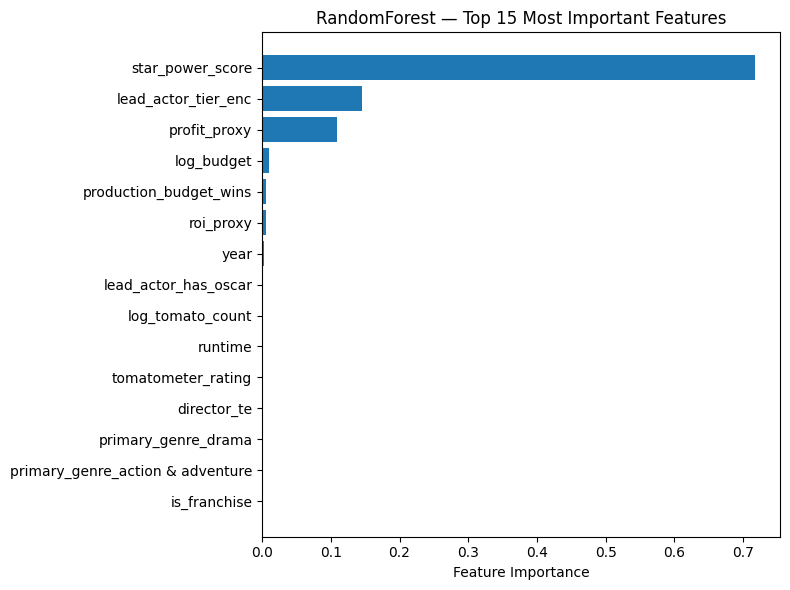

In [ ]:

# Log-gross full model
rf_best = best_log_models["RandomForest"]
numeric_features     = num_log
categorical_features = cat_log


# Extract preprocessor + model
preprocessor = rf_best.named_steps["preprocess"]
model        = rf_best.named_steps["model"]


# Retrieve feature names from preprocessing pipeline

# OneHotEncoder inside ColumnTransformer
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Full list (numeric first, then OHE expansion)
feature_names = np.concatenate([numeric_features, ohe_feature_names])


# RandomForest feature importances

importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 15 Most Important Features")
plt.tight_layout()
plt.show()


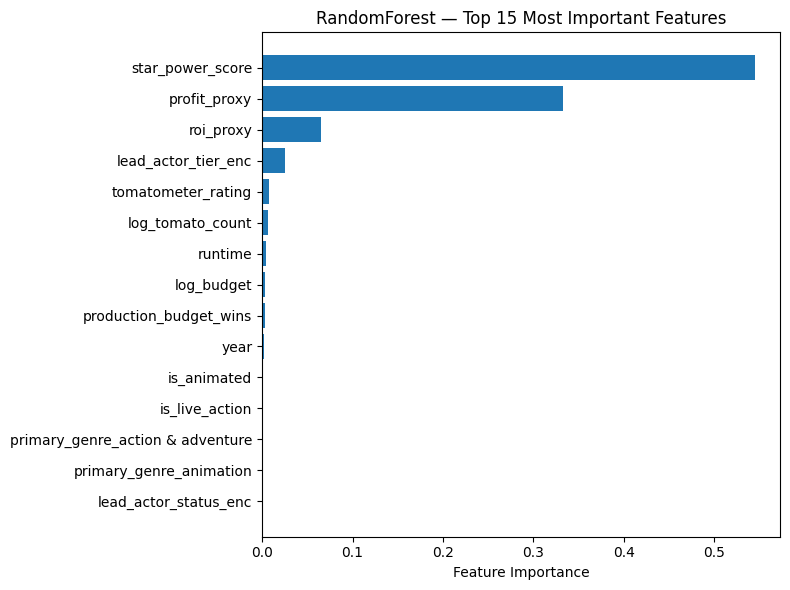

In [ ]:

# Blockbusters
rf_best = best_block_models["RandomForest"]
numeric_features     = num_b
categorical_features = cat_b


# Extract preprocessor + model
preprocessor = rf_best.named_steps["preprocess"]
model        = rf_best.named_steps["model"]

# 2. Retrieve feature names from preprocessing pipeline

# OneHotEncoder inside ColumnTransformer
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Full list (numeric first, then OHE expansion)
feature_names = np.concatenate([numeric_features, ohe_feature_names])

# RandomForest feature importances
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 15 Most Important Features")
plt.tight_layout()
plt.show()


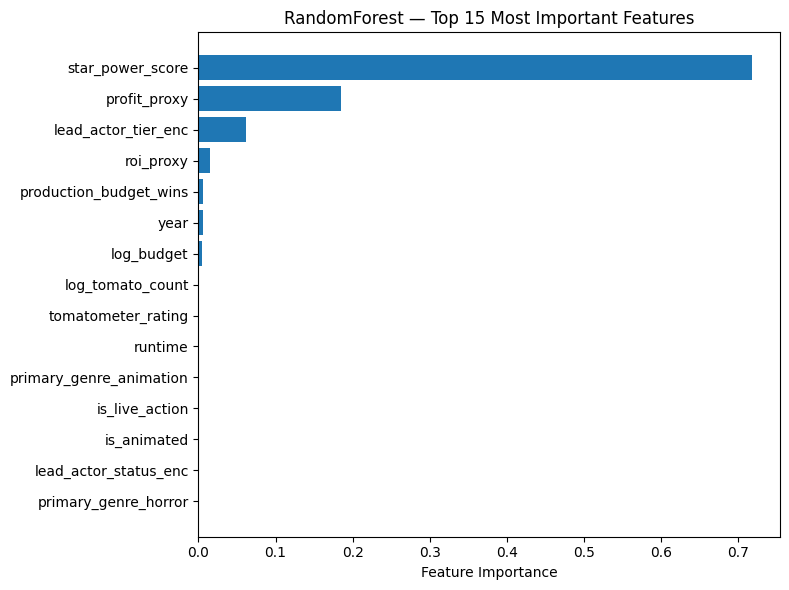

In [ ]:

# Non-blockbusters
rf_best = best_nonblock_models["RandomForest"]
numeric_features     = num_nb
categorical_features = cat_nb


# Extract preprocessor + model

preprocessor = rf_best.named_steps["preprocess"]
model        = rf_best.named_steps["model"]

# Retrieve feature names from preprocessing pipeline-

# OneHotEncoder inside ColumnTransformer
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Full list (numeric first, then OHE expansion)
feature_names = np.concatenate([numeric_features, ohe_feature_names])

#RandomForest feature importances
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 15 Most Important Features")
plt.tight_layout()
plt.show()


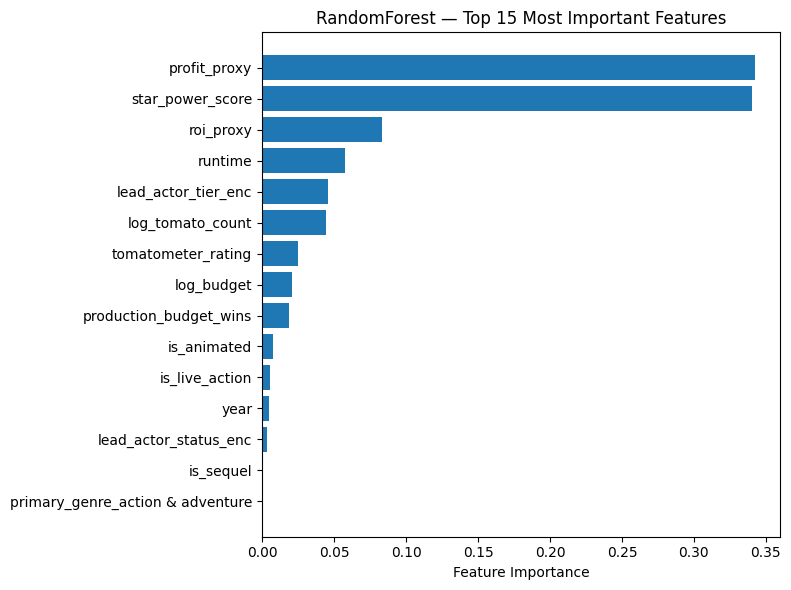

In [ ]:
# Franchise
rf_best = best_franchise_models["RandomForest"]
numeric_features     = num_f
categorical_features = cat_f

# Extract preprocessor + model
preprocessor = rf_best.named_steps["preprocess"]
model        = rf_best.named_steps["model"]

# Retrieve feature names from preprocessing pipeline


# OneHotEncoder inside ColumnTransformer
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Full list (numeric first, then OHE expansion)
feature_names = np.concatenate([numeric_features, ohe_feature_names])

# RandomForest feature importances
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 15 Most Important Features")
plt.tight_layout()
plt.show()


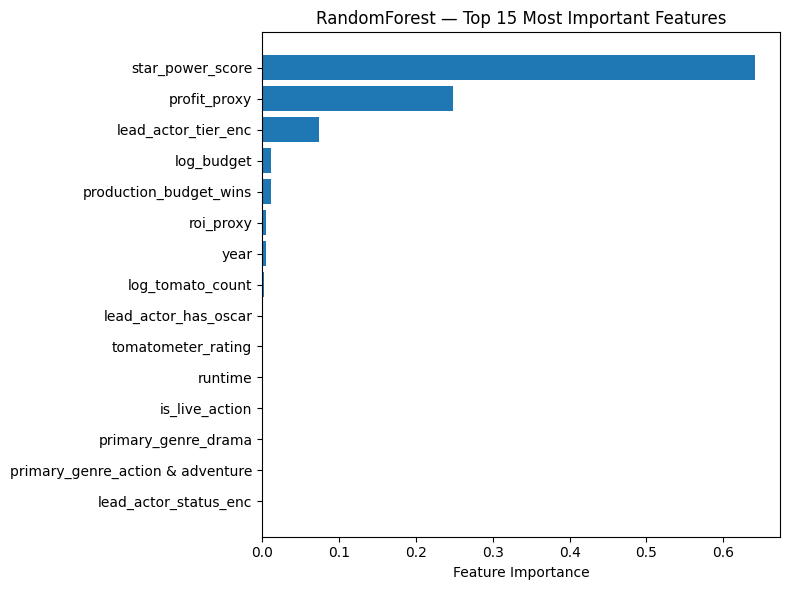

In [ ]:
# Standalone
rf_best = best_standalone_models["RandomForest"]
numeric_features     = num_s
categorical_features = cat_s

# Extract preprocessor + model
preprocessor = rf_best.named_steps["preprocess"]
model        = rf_best.named_steps["model"]

# Retrieve feature names from preprocessing pipeline

# OneHotEncoder inside ColumnTransformer
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Full list (numeric first, then OHE expansion)
feature_names = np.concatenate([numeric_features, ohe_feature_names])

# RandomForest feature importances
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:15]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 15 Most Important Features")
plt.tight_layout()
plt.show()


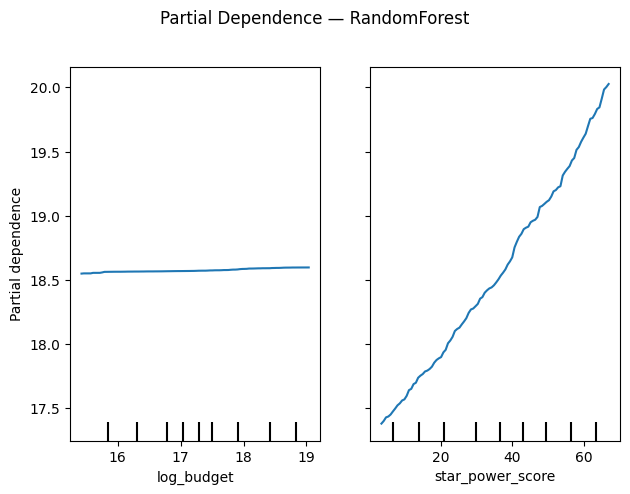

In [ ]:


# log_worldwide_gross
rf_best = best_log_models["RandomForest"]
X_for_pdp = Xtr_log     # training data BEFORE preprocessing

# PDP FEATURES
features_for_pdp = ["log_budget", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


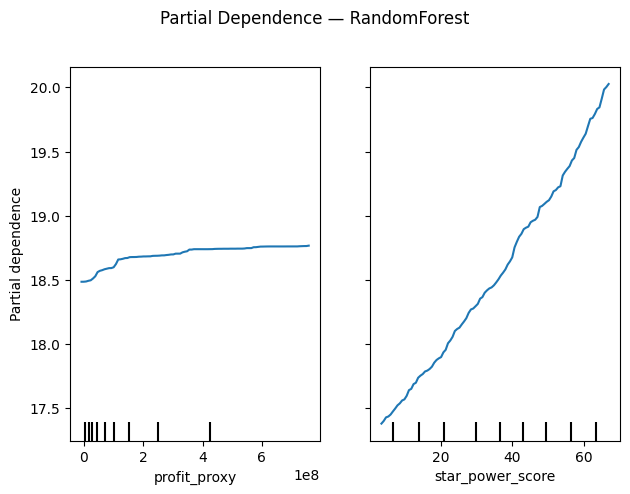

In [ ]:


# log_worldwide_gross
rf_best = best_log_models["RandomForest"]
X_for_pdp = Xtr_log     # training data BEFORE preprocessing



# PDP FEATURES
features_for_pdp = ["profit_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


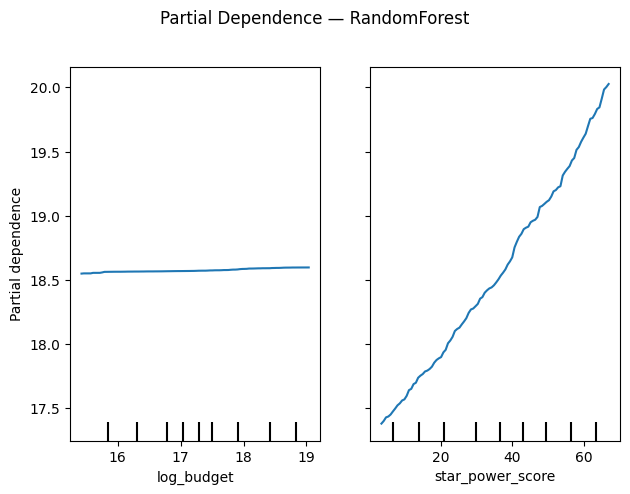

In [ ]:


# log_worldwide_gross
rf_best = best_log_models["RandomForest"]
X_for_pdp = Xtr_log     # training data BEFORE preprocessing


# PDP FEATURES
features_for_pdp = ["log_budget", "star_power_score"]


# PDPs
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


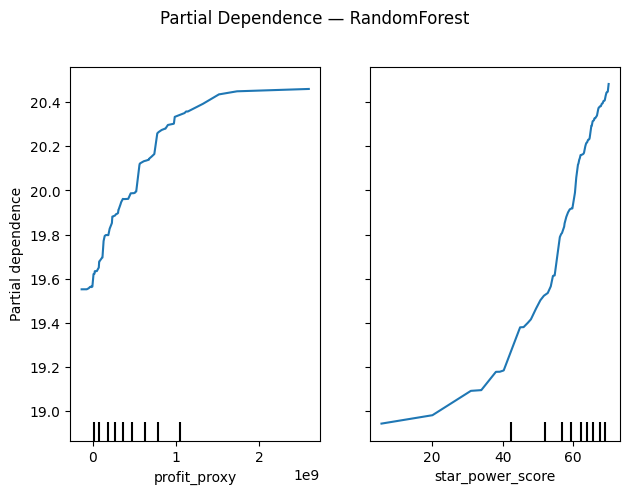

In [ ]:

# Blockbusters
rf_best = best_block_models["RandomForest"]
X_for_pdp = Xtr_b


# PDP FEATURES
features_for_pdp = ["profit_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


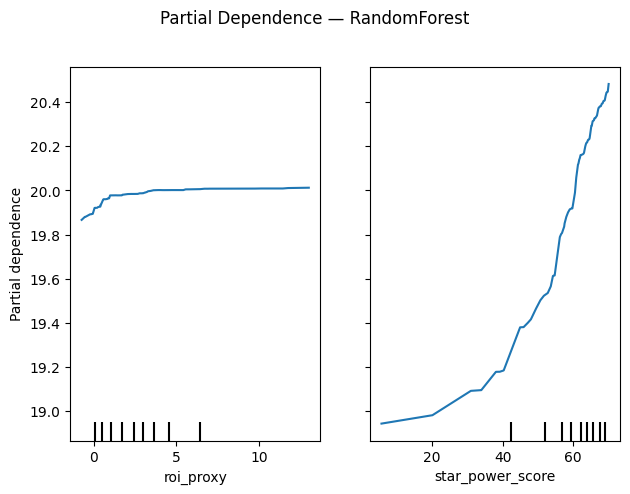

In [ ]:

# Blockbusters
rf_best = best_block_models["RandomForest"]
X_for_pdp = Xtr_b

# PDP FEATURES
features_for_pdp = ["roi_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


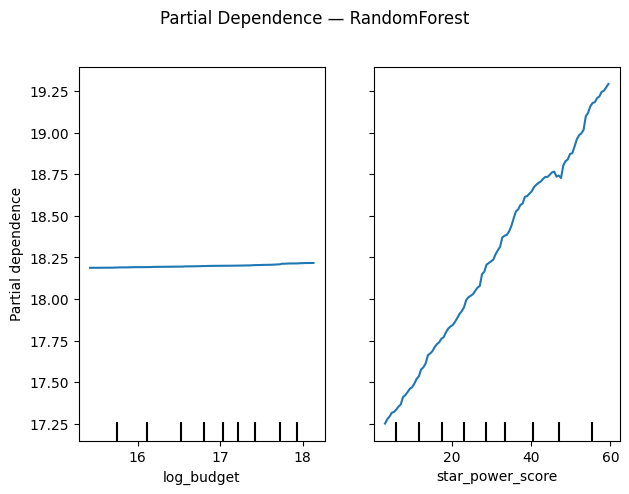

In [ ]:

# Non-blockbusters
rf_best = best_nonblock_models["RandomForest"]
X_for_pdp = Xtr_nb



# PDP FEATURES
features_for_pdp = ["log_budget", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


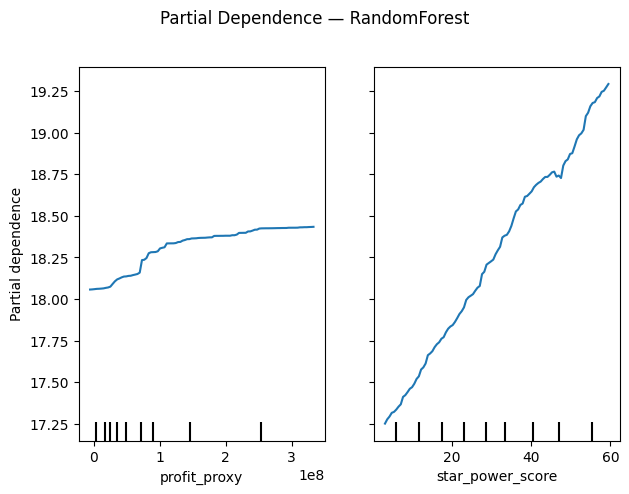

In [ ]:

# Non-blockbusters
rf_best = best_nonblock_models["RandomForest"]
X_for_pdp = Xtr_nb


# PDP FEATURES
features_for_pdp = ["profit_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


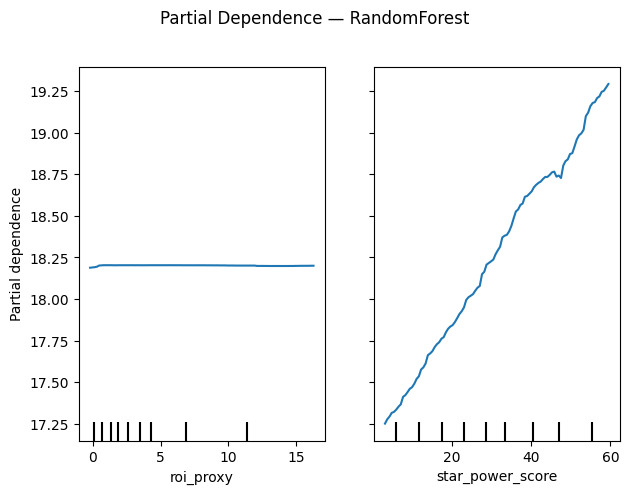

In [ ]:

# Non-blockbusters
rf_best = best_nonblock_models["RandomForest"]
X_for_pdp = Xtr_nb


# PDP FEATURES
features_for_pdp = ["roi_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


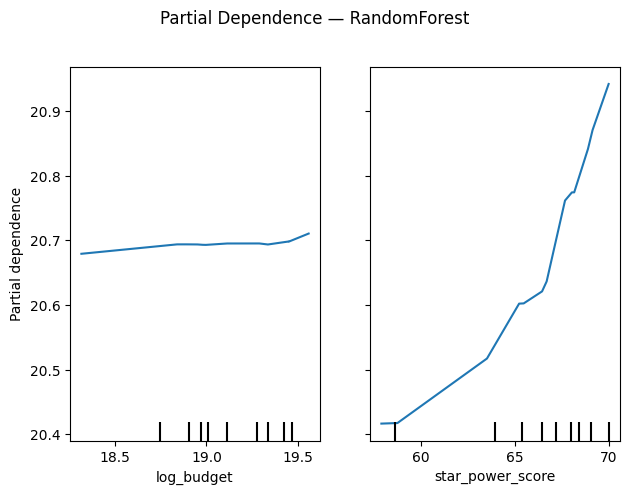

In [ ]:
# Franchise
rf_best = best_franchise_models["RandomForest"]
X_for_pdp = Xtr_f

# PDP FEATURES
features_for_pdp = ["log_budget", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


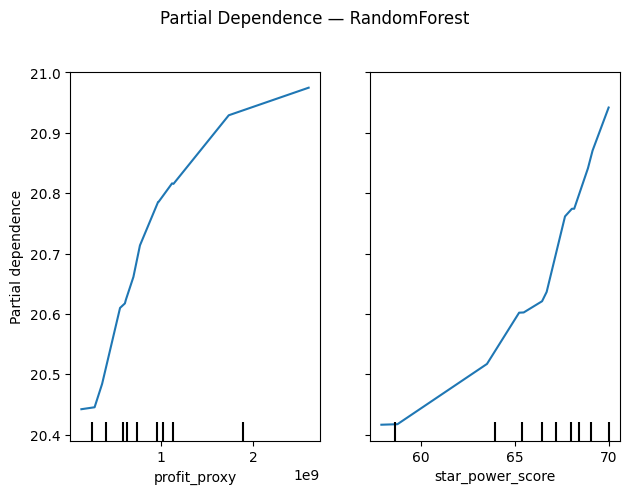

In [ ]:
# Franchise
rf_best = best_franchise_models["RandomForest"]
X_for_pdp = Xtr_f

# PDP FEATURES
features_for_pdp = ["profit_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


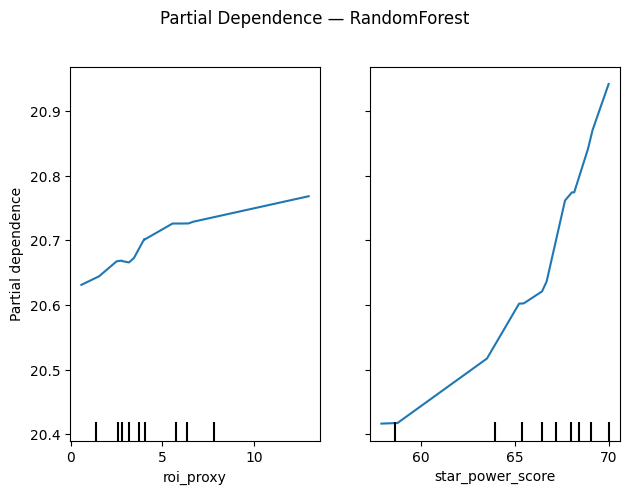

In [ ]:
# Franchise
rf_best = best_franchise_models["RandomForest"]
X_for_pdp = Xtr_f

# PDP FEATURES
features_for_pdp = ["roi_proxy", "star_power_score"]

# PDP
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


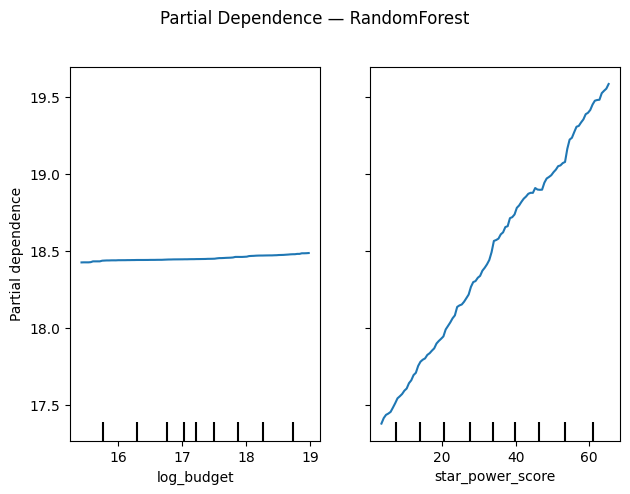

In [ ]:
# Standalone
rf_best = best_standalone_models["RandomForest"]
X_for_pdp = Xtr_s

# PDP FEATURES
features_for_pdp = ["log_budget", "star_power_score"]

# PDP's
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


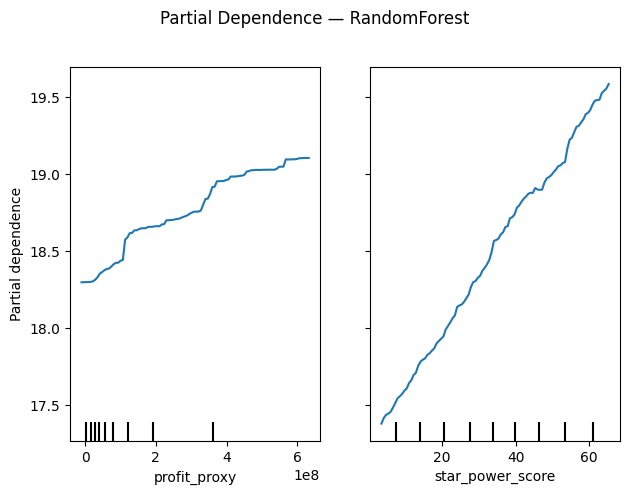

In [ ]:
# Standalone
rf_best = best_standalone_models["RandomForest"]
X_for_pdp = Xtr_s

# PDP FEATURES
features_for_pdp = ["profit_proxy", "star_power_score"]

# PDP's
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


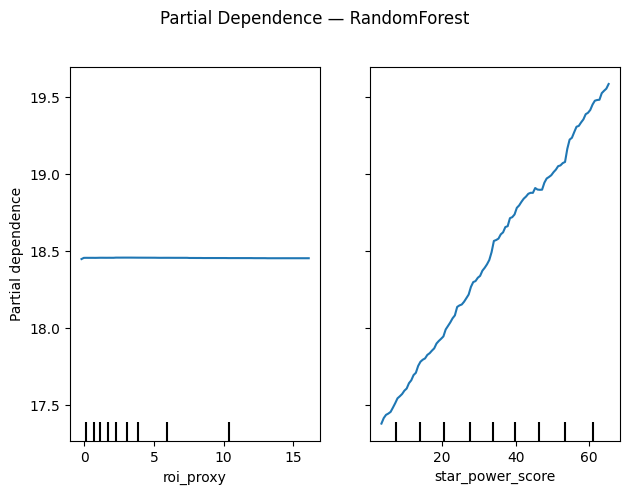

In [ ]:
# Standalone
rf_best = best_standalone_models["RandomForest"]
X_for_pdp = Xtr_s


# PDP FEATURES
features_for_pdp = ["roi_proxy", "star_power_score"]

# PDPs
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_for_pdp,
    features=features_for_pdp,
    kind="average",
)

plt.suptitle("Partial Dependence — RandomForest", y=1.02)
plt.tight_layout()
plt.show()


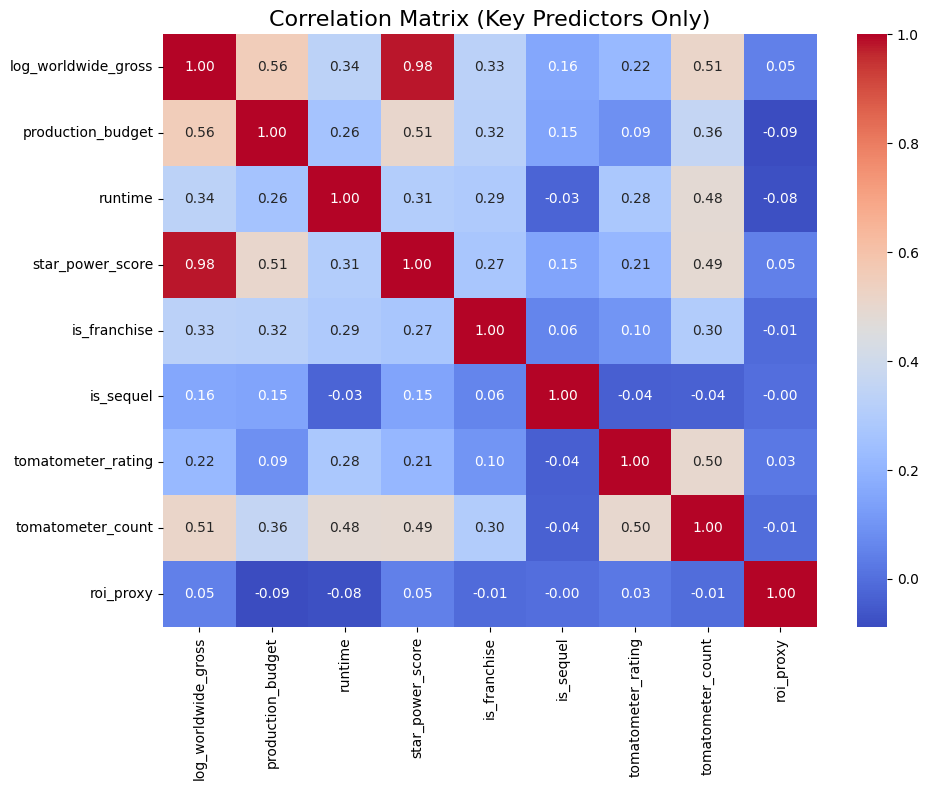

In [ ]:
import seaborn as sns

key_features = [
    "log_worldwide_gross",
    "production_budget", "runtime", "star_power_score",
    "is_franchise", "is_sequel",
    "director_te", "lead_actor_te",
    "tomatometer_rating", "tomatometer_count",
    "roi_proxy"
]

key_features = [c for c in key_features if c in df.columns]

corr_key = df[key_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_key, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Key Predictors Only)", fontsize=16)
plt.tight_layout()
plt.show()
